# Data Access

__NOTE:__ Changes have been made to this notebook to orient images with the vertical coordinate increasing downwards.

__As before, the recommended use of this Notebook is to make an editable copy, clear all output, and step through it, cell-by-cell.__

Data access is analogous to what was introduced in the 1st HandsOn, but with changes of details such as orientation, and possibly access to additional variables, such as temperature and opacity, through the "aux" feature in the code -- more may be added here about that.

### Basic visualization

In [1]:
import os
import sys
TOP=os.environ['HOME']+'/codes/dispatch/'
sys.path.append(TOP+'utilities/python')
import dispatch
import dispatch.select   as dse
import dispatch.graphics as dgr
os.chdir(TOP+'experiments/stellar_atmospheres')

#### Open a snapshot

In [2]:
sn=dispatch.snapshot(3,'myrun')
print('time: {:.1f} seconds'.format(sn.time*100))

time: 30.0 seconds


Using the ``my_plane`` procedure should work as before, except is doesn't, since the size of this snapshot in code units (Mm) is 6x6x3, not 1x1x1, so as is the ``my_plane`` procedure will only show a 1x1 Mm corner of the xy-plane.  So we need to pick up more meta-data.  To figure out what, look at the ``sn`` object again:

In [3]:
vars(sn)

{'copy': False,
 'datadir': 'data/myrun/00003',
 'rundir': 'data/myrun',
 'nml_list': Namelist([('io_nml',
            Namelist([('format', 6),
                      ('ntotal', 108),
                      ('out_time', 0.1),
                      ('guard_zones', False),
                      ('time_derivs', 0),
                      ('method', 'parallel')])),
           ('snapshot_nml',
            Namelist([('ioformat', 6),
                      ('iout', 3),
                      ('time', 0.3),
                      ('ntotal', 108),
                      ('istep', 477),
                      ('mesh_type', 1),
                      ('position', array([5.5, 1.5, 0. ])),
                      ('size', array([1., 1., 1.])),
                      ('ds', array([0.03125, 0.03125, 0.03125])),
                      ('box', array([6., 6., 3.])),
                      ('velocity', array([0., 0., 0.])),
                      ('level', 8),
                      ('quality', 0.0),
                   

You will find that there is an ``sn.box`` property that contains the expected 6,6,3 values, and an ``sn.cartesian.origin`` that gives the origin.  Use it to change the limits.  Like this, for example:

There are some other changes that are nice to include, which result in xz- and yz-planes being opriented with z increasing downwards on the screen.

Working these out yourself is good Python training.  If instead you prefer to "cheat", here is one possible version, with also a couple of extra parameters added:

In [4]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as pl

def solar_plane(sn,v='d',log=False,ix=None,iy=None,iz=0,i=None,vmin=None,vmax=None,patches=None,
             colorbar=True,cmap='coolwarm',title=None):
    """ Procedure to make an image of a DISPATCH unigrid snapshot in a plane """

    # Clear graphics
    pl.clf()

    # Choose patch plane
    origin=sn.cartesian.origin
    if type(ix) is int:
        dir=0
        ii=ix
        pl.xlabel('y'); pl.ylabel('z')
        xlim=(origin[1],origin[1]+sn.box[1])
        ylim=(origin[2]+sn.box[2],origin[2])
    elif type(iy) is int:
        dir=1
        ii=iy
        pl.xlabel('x'); pl.ylabel('z')
        ylim=(origin[2]+sn.box[2],origin[2])
        xlim=(origin[0],origin[0]+sn.box[0])
    elif type(iz) is int:
        pl.xlabel('x'); pl.ylabel('y')
        dir=2
        ii=iz
        xlim=(origin[0],origin[0]+sn.box[0])
        ylim=(origin[1],origin[1]+sn.box[1])
    ss=np.unique(np.sort([p.position[dir] for p in sn.patches]))
    pp=[p for p in sn.patches if p.position[dir] == ss[ii]]

    # Clear graphics and set limits
    pl.xlim(xlim)
    pl.ylim(ylim)

    # Determine min and max, if not given
    if not vmin:
        vmin=1e10
        for p in pp:
            vmin=min(vmin,p.var(v).min())
    if not vmax:
        vmax=-1e10
        for p in pp:
            vmax=max(vmax,p.var(v).max())
    vmin=np.log(vmin) if log else vmin
    vmax=np.log(vmax) if log else vmax
    
    # Choose index in patch -- mid-plane if not given as parameter
    if i is None:
        i=sn.n[dir]//2
    
    # Make the images
    for p in pp:
        f=np.log(p.var(v)) if log else p.var(v)
        if dir==0:
            pl.imshow(f[i,:,:].T,origin='lower',extent=p.extent[dir],vmin=vmin,vmax=vmax,cmap=cmap)
        elif dir==1:
            e=p.extent[dir]
            e=[e[2],e[3],e[0],e[1]]
            pl.imshow(f[:,i,:].T,origin='lower',extent=e,vmin=vmin,vmax=vmax,cmap=cmap)
        else:
            pl.imshow(f[:,:,i].T,origin='lower',extent=p.extent[dir],vmin=vmin,vmax=vmax,cmap=cmap)
    
    # Optionally, show patches
    if patches:
        for p in pp:
            e=p.extent[dir]
            x=[e[0],e[0],e[1],e[1],e[0]]
            y=[e[2],e[3],e[3],e[2],e[2]]
            pl.plot(x,y,color='grey')

    # add a colorbar, if not supressed
    if colorbar:
        pl.colorbar()

    # Allow custom title
    if title is None:
        pos=p.xyz[dir][i]
        title='v:{}  dir:{}  pos:{:.2f} t:{:.2f}'.format(v,dir,pos,sn.time)
    pl.title(title)

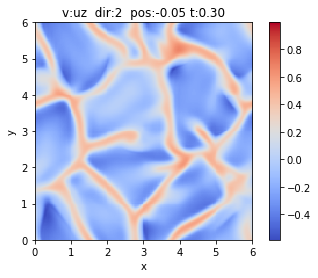

In [5]:
solar_plane(sn,v='uz',iz=0,patches=0)

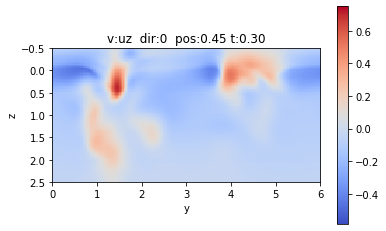

In [6]:
solar_plane(sn,v='uz',ix=0,patches=0)

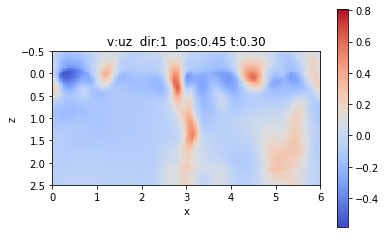

In [7]:
solar_plane(sn,v='uz',iy=0,patches=0)

### Showing a slice of the vertical magnetic field

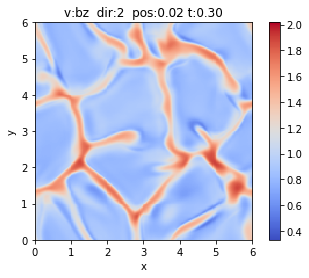

In [8]:
solar_plane(sn,v='bz',iz=0,i=18,patches=0)

As you can see, I've changed the default colormap (to ``'coolwarm'``).  You may want to do that too:

In general, tune such ad-hoc procedures to your liking -- your needs (and taste) may differ ;-). 